<a href="https://colab.research.google.com/github/gilsonauerswald/Bioinformatic_Projects/blob/main/P_integration_across_independent_studies_with_MINT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study of MINT sPLS-DA with Stem Cell dataset**
The aim of this P-integrative analysis is to generate a model which can classify novel samples into one of a set of stem cell classes based on their genomic information.

# **We First load mixOmics:**

In [ ]:
install.packages("BiocManager")
BiocManager::install("mixOmics")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.23), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'mixOmics'

also installing the dependencies ‘formatR’, ‘RcppEigen’, ‘lambda.r’, ‘futile.options’, ‘plyr’, ‘Rcpp’, ‘RSpectra’, ‘futile.logger’, ‘snow’, ‘BH’, ‘igraph’, ‘ellipse’, ‘corpcor’, ‘reshape2’, ‘matrixStats’, ‘rARPACK’, ‘gridExtra’, ‘ggrepel’, ‘BiocParallel’


Old packages: 'backports', 'bit', 'brio', 'broom', 'bslib', 'cachem', 'callr',
  'cli', 'crayon', 'curl', 'data.table', 'DBI', 'dbplyr', 'devtools', 'digest',
  'evaluate', 'farver', 'fastmap', 'fs', 'gargle', 'ggplot2', 'gh', 'gtable',
  'highr', 'htmltools', 'httr2', 'isoband', 'knitr', 'munsell', 'openssl',
  'pkgbuild', 'pkgload', 'processx'

In [ ]:
library(mixOmics)

Loading required package: MASS

Loading required package: lattice

Loading required package: ggplot2


Loaded mixOmics 6.28.0
Thank you for using mixOmics!
Tutorials: http://mixomics.org
Bookdown vignette: https://mixomicsteam.github.io/Bookdown
Questions, issues: Follow the prompts at http://mixomics.org/contact-us
Cite us:  citation('mixOmics')




# **Load Data**
In their original study they integrated 15 transcriptomics microarray stem cells datasets to classify three
types of human cells: human Fibroblasts (Fib), human Embryonic Stem Cells (hESC) and human
induced Pluripotent Stem Cells (hiPSC). Here we illustrate only a subset of those data, including 4
transcriptomics studies (125 samples in total) and the levels of expression of 400 transcripts. The
data were obtained from the Stemformatics database.

In [ ]:
data(stemcells)

#the combined data set X
X = stemcells$gene
dim(X)

[1] 125 400

In [ ]:
# the outcome vector Y:
Y = stemcells$celltype
length(Y)
summary(Y)

[1] 125

Fibroblast       hESC      hiPSC 
        30         37         58

In [ ]:
# the vector indicating each independent study
study = stemcells$study
# number of samples per study:
summary(study)

1  2  3  4 
38 51 21 15

In [ ]:
# experimental design
table(Y,study)

            study
Y             1  2  3  4
  Fibroblast  6 18  3  3
  hESC       20  3  8  6
  hiPSC      12 30 10  6

# **MINT PLS-DA**
We first perform a MINT PLS-DA with all variables included in the model and ncomp = 2 components.


In [ ]:
mint.plsda.res.perf = mint.plsda(X = X, Y = Y, study = study, ncomp = 2)

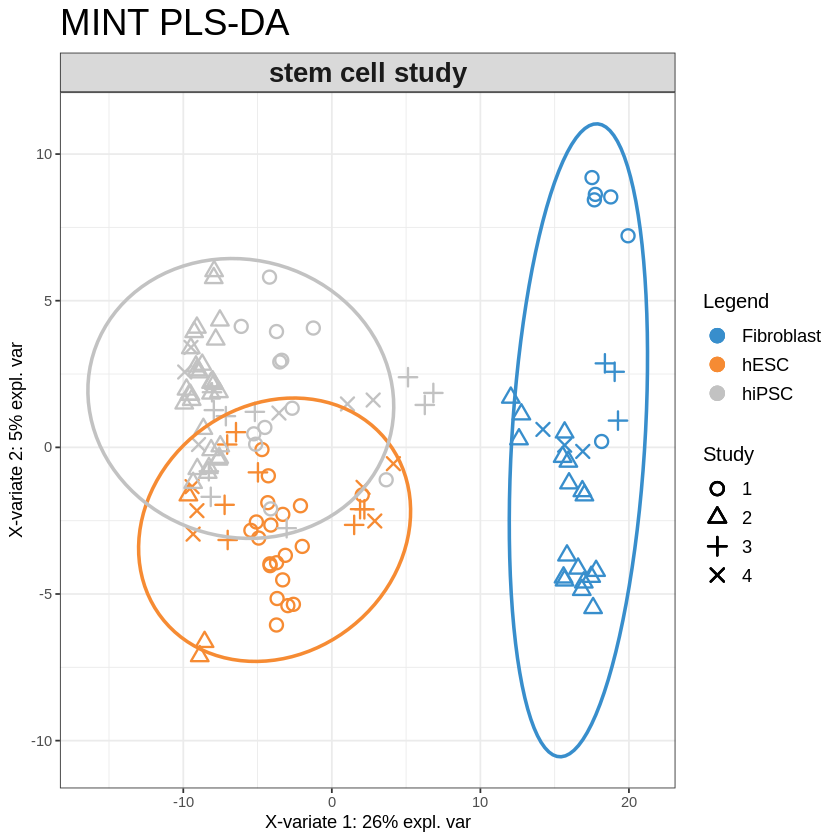

In [ ]:
#mint.plsda.res # lists the different functions
plotIndiv(mint.plsda.res, legend = TRUE, title = 'MINT PLS-DA',
          subtitle = 'stem cell study', ellipse = T)

# **MINT sparse PLS-DA**
The MINT PLS-DA model is built on all 400 genes in X, many of which may be uninformative to
characterise the different classes. The MINT sPLS-DA analysis aims to identify a small subset of
genes that best discriminate the classes.

In [ ]:
basic.splsda.model <- mint.plsda(X, Y, study = study, ncomp = 5)

## **Choice of parameters**
We first tune the keepX parameter using the tune function for a MINT object. The function
performs Leave-One-Group-Out-Cross-Validation (LOGOCV) for different values of test.keepX
provided on each component, therefore no repeated CV is needed. Based on the mean classification
error rate (overall error rate or BER), it will output the optimal number of component ncomp and
the optimal keepX to be included in the final model.

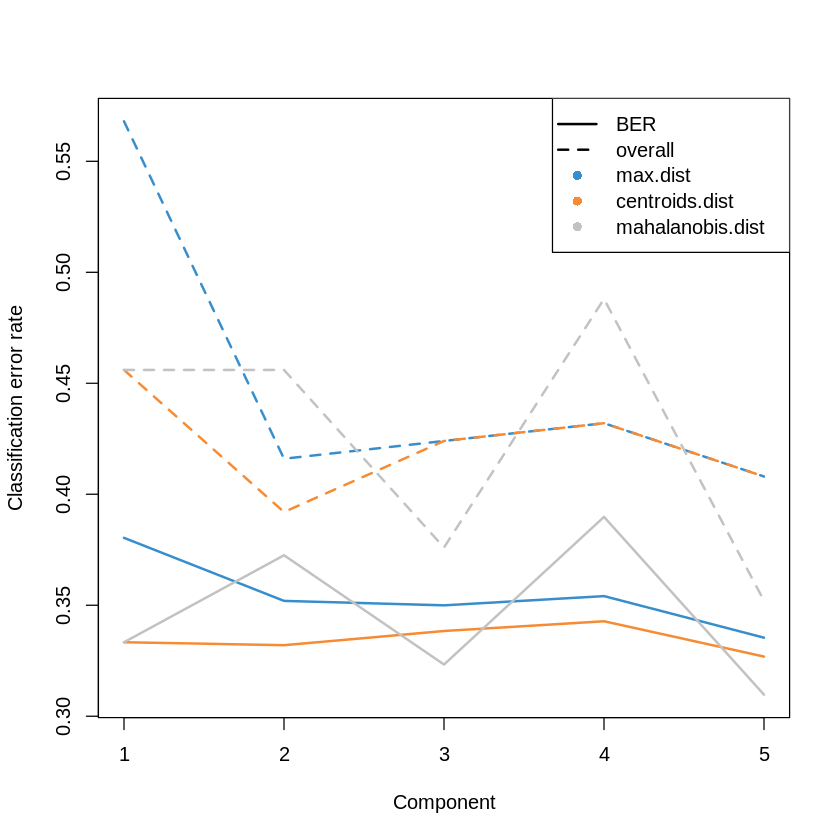

In [ ]:
set.seed(5249) # For reproducible results here, remove for your own analyses

splsda.perf <- perf(basic.splsda.model) # undergo performance optimisation
plot(splsda.perf)

In [ ]:
splsda.perf$choice.ncomp

,max.dist,centroids.dist,mahalanobis.dist
overall,1,1,1
BER,1,1,1


In [ ]:
optimal.ncomp <- 2

In [ ]:
tune.mint <- tune(X = X, Y = Y, study = study,  # tune the number of features
                              ncomp = optimal.ncomp,# using optimal comp number
                              test.keepX = seq(1, 100, 1),
                              method = 'mint.splsda',
                              measure = 'BER', # balanced error rate
                              dist = "max.dist")

Calling 'tune.mint.splsda' with Leave-One-Group-Out Cross Validation (nrepeat = 1)



Note: sd bars cannot be calculated when nrepeat = 1.




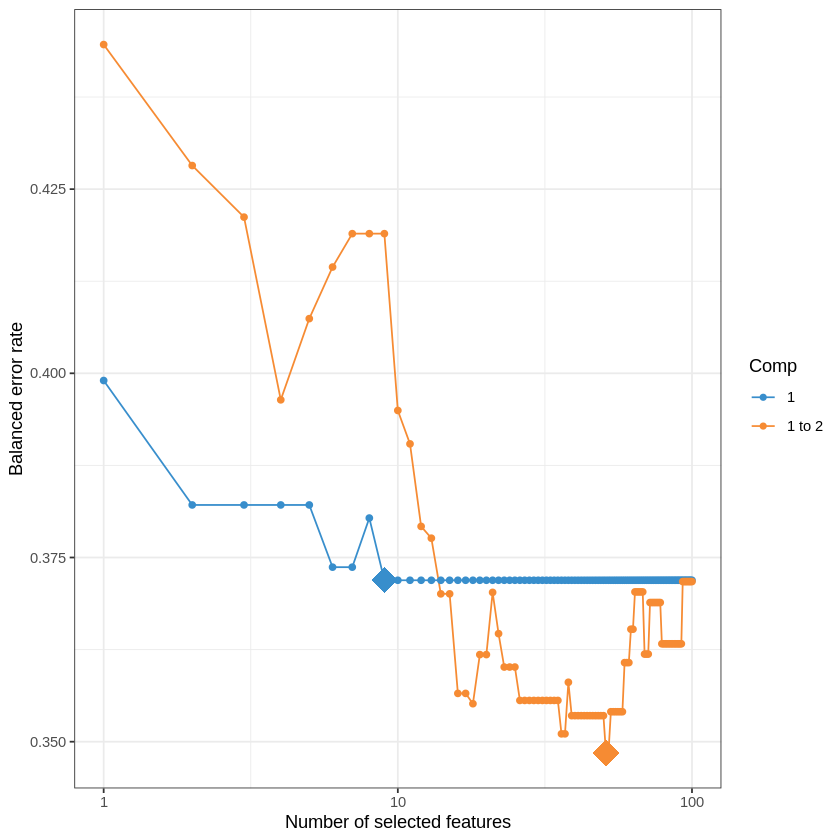

In [ ]:
plot(tune.mint, sd = FALSE)

In [ ]:
# optimal number of components
tune.mint$choice.ncomp

,comp1,comp2
1,0.3611111,0.4666667
2,0.3333333,0.2222222
3,0.4333333,0.4916667
4,0.4444444,0.2777778


In [ ]:
optimal.keepX <- tune.mint$choice.keepX # extract optimal values

optimal.keepX

comp1 comp2 
    9    51

## **Final MINT sPLS-DA model**
Following the tuning results, our final MINT sPLS-DA model is as follows. Note that we still chose
a model with 2 components in order to obtain 2D graphics.

In [ ]:
mint.splsda.res = mint.splsda(X = X, Y = Y, study = study, ncomp = optimal.ncomp,
                              keepX = optimal.keepX)

#mint.splsda.res   # lists useful functions that can be used with a MINT object

## **Sample plots**
The samples can be projected on the global components:

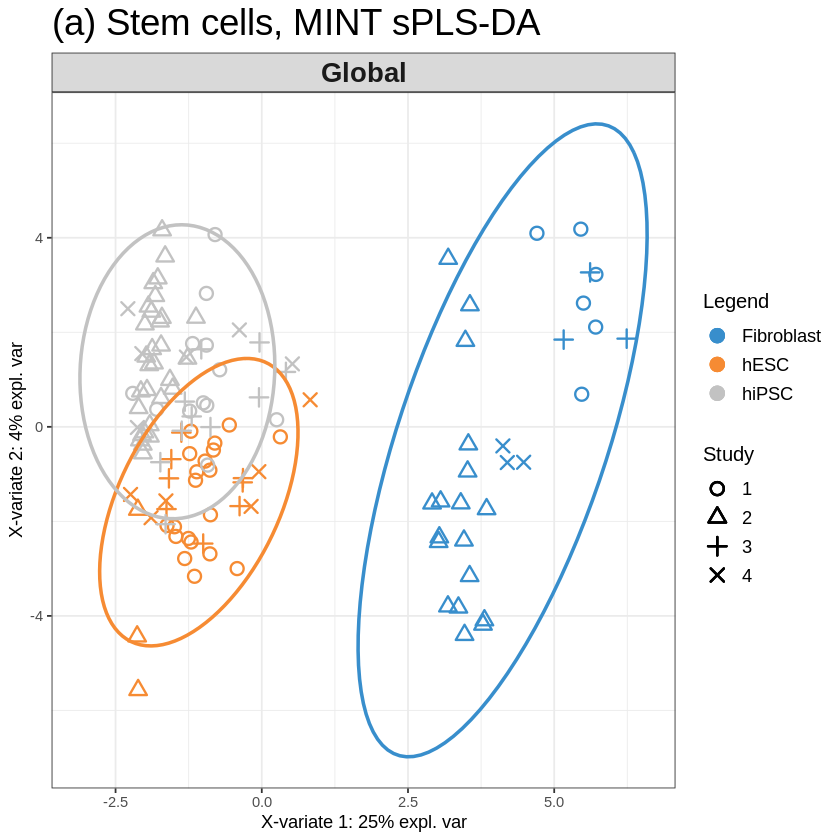

In [ ]:
plotIndiv(mint.splsda.res, study = 'global',
          legend = TRUE,
          title = '(a) Stem cells, MINT sPLS-DA',
          subtitle = 'Global', ellipse = T)

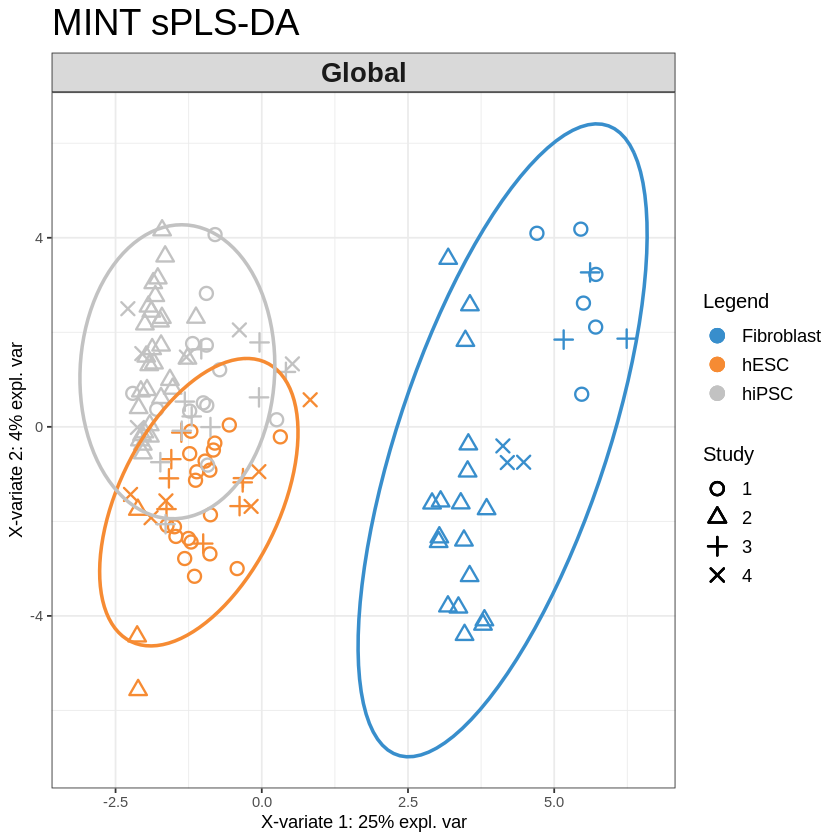

In [ ]:
plotIndiv(mint.splsda.res, study = 'global', legend = TRUE, title = 'MINT sPLS-DA',
          subtitle = 'Global', ellipse=T)

Or, alternatively using the MINT PLS-component from each study. This options allows us to
examine each study individually.

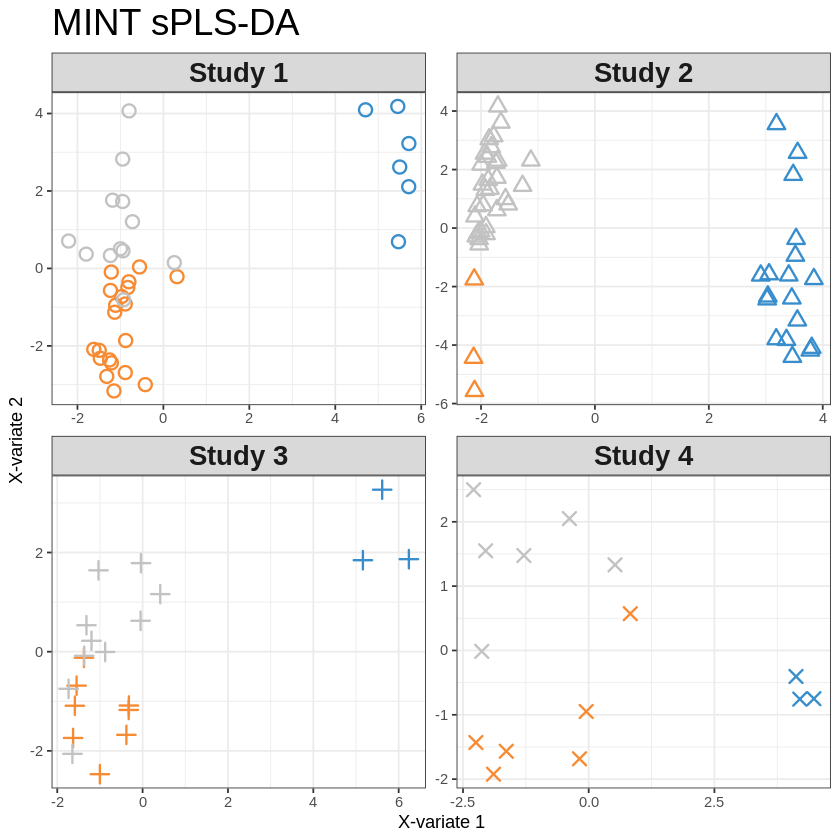

In [ ]:
plotIndiv(mint.splsda.res, study = 'all.partial',  title = 'MINT sPLS-DA',
          subtitle = paste("Study",1:4))

## **Variable Plot**

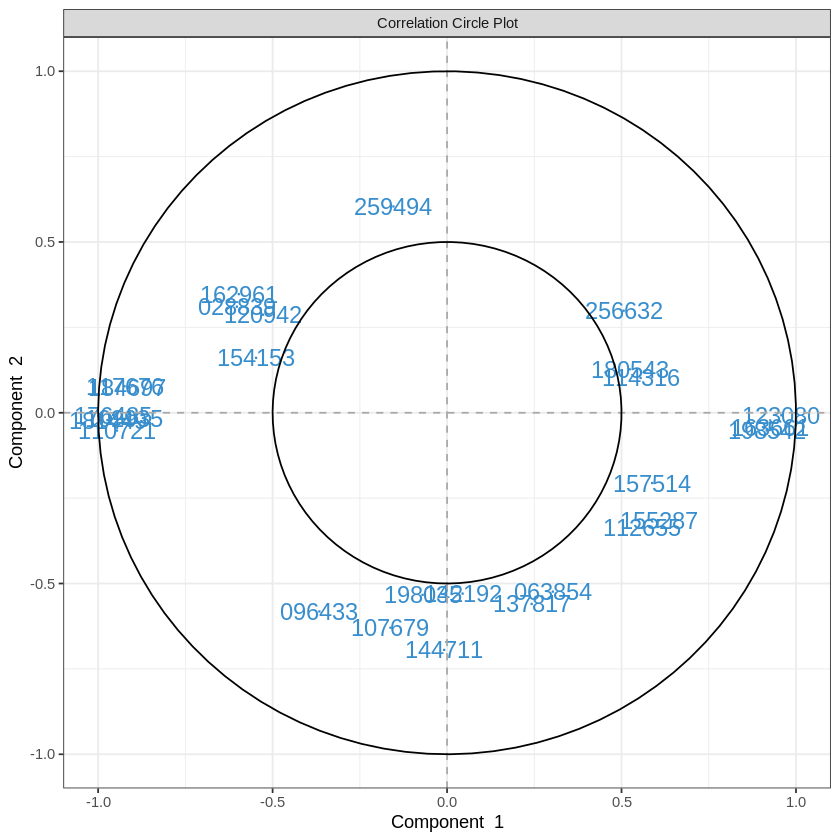

In [ ]:
# all gene names have the same first 10 characters,
# shorten all the names to reduce visual clutter
shortenedNames <- list(unlist(lapply(mint.splsda.res$names$colnames$X,
                                     substr, start = 10, stop = 16)))

plotVar(mint.splsda.res,
        cutoff = 0.5,
        var.names = shortenedNames)

## **Clustered Image Map (CIM)**
A Clustered Image Map including the final gene signature is plotted (default values to Euclidian
distance and Complete linkage). Specific component can be also be chosen.

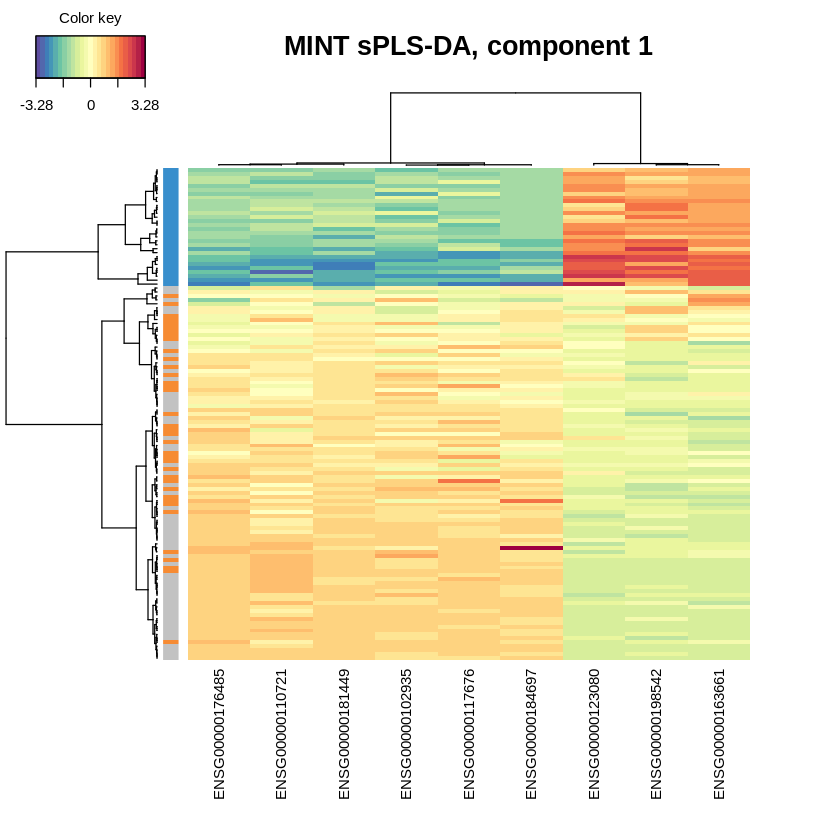

In [ ]:
cim(mint.splsda.res, comp = 1, margins=c(10,5),
    row.sideColors = color.mixo(as.numeric(Y)), row.names = FALSE,
    title = "MINT sPLS-DA, component 1")

## **Loading plots**
Finally the plotLoadings function displays the coefficient weight of each selected variable in each
study and shows the agreement of the gene signature across studies. Colors indicate the class in
which the mean expression value of each selected gene is maximal. For component 1:

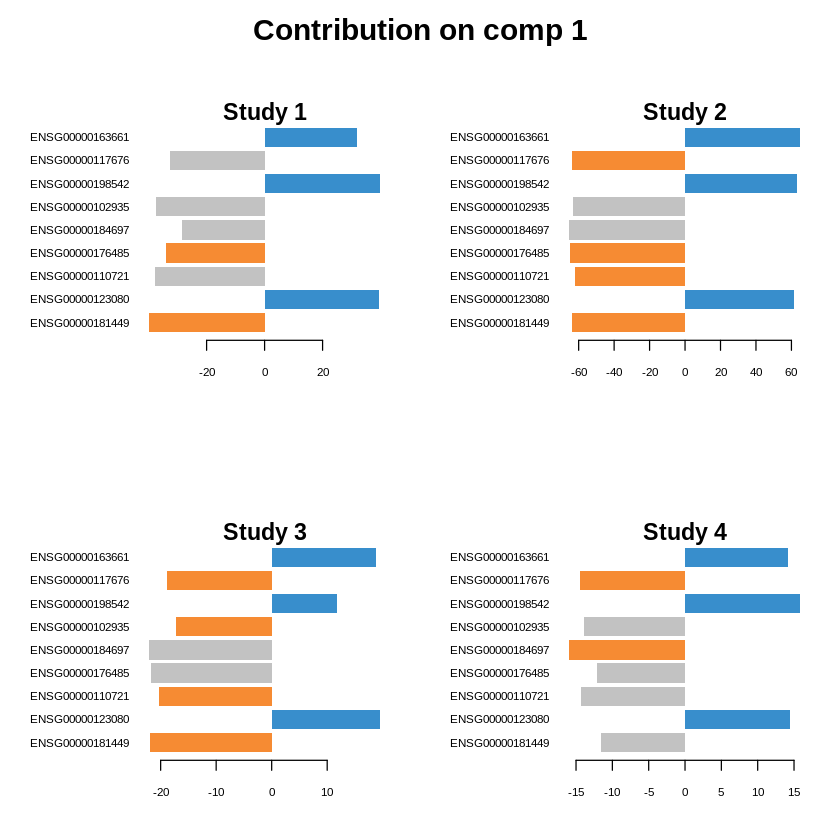

In [ ]:
plotLoadings(mint.splsda.res, contrib="max", method = 'mean', comp=1,
             study="all.partial", legend=FALSE, title="Contribution on comp 1",
             subtitle = paste("Study",1:4))

The last variable plot to be used is the Relevance network. This provides similar insights to the CIM above. Only the associations between the selected genes and the cell type (dummy encoded).

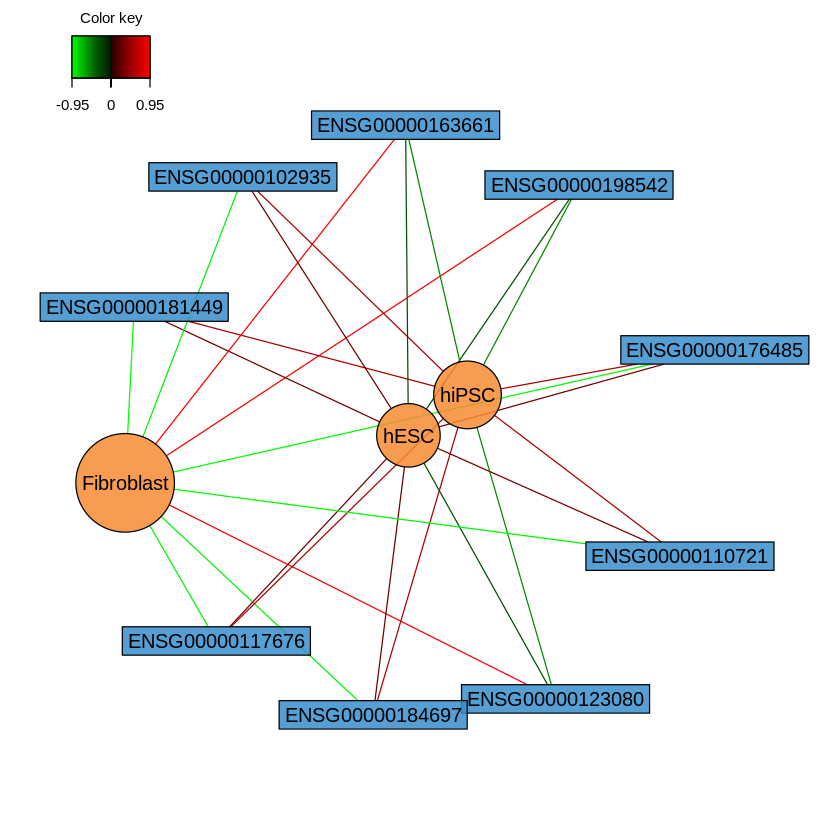

In [ ]:
network(mint.splsda.res, comp = 1,
        color.node = c(color.mixo(1), color.mixo(2)),
        shape.node = c("rectangle", "circle"))

## **Performance assessment and prediction**
The performance of the MINT sPLS-DA model can be assessed with the perf function. Since the
previous tuning of the MINT sPLS-DA model was conducted with the distance max.dist, the same
distance is used to assess the performance of the final model.

In [ ]:
set.seed(123)
t1 = proc.time()
perf.mint = perf(mint.splsda.res, progressBar = FALSE, dist = 'max.dist')
t2 = proc.time()
running_time = t2 - t1; running_time

perf.mint$global.error

   user  system elapsed 
  0.403   0.000   0.410 

$BER
       max.dist
comp1 0.3719111
comp2 0.3484667

$overall
      max.dist
comp1    0.560
comp2    0.408

$error.rate.class
$error.rate.class$max.dist
               comp1     comp2
Fibroblast 0.0000000 0.0000000
hESC       0.9189189 0.6486486
hiPSC      0.6206897 0.4655172

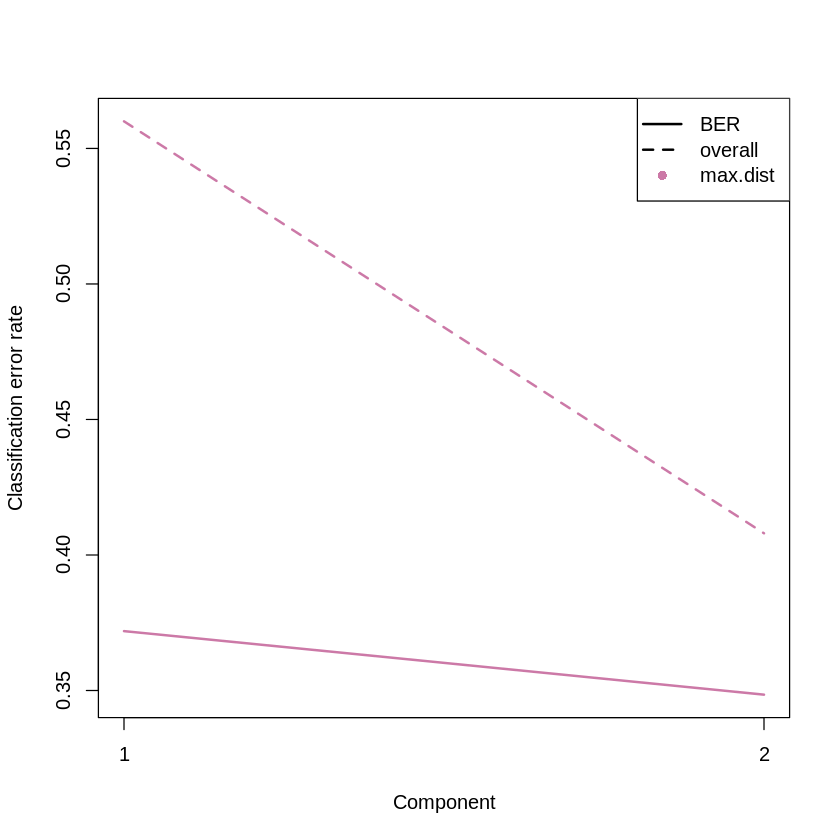

In [ ]:
plot(perf.mint, col = color.mixo(5))

A predict function is also available to predict the class membership of new test samples from
an external study.

In [ ]:
# we predict on study 3
ind.test = which(study == "3")
test.predict <- predict(mint.splsda.res, newdata = X[ind.test, ], dist = "max.dist",
                        study.test = factor(study[ind.test]))
Prediction <- test.predict$class$max.dist[, 2]

In [ ]:
# the confusion table compares the real subtypes with the predicted subtypes
get.confusion_matrix(truth = Y[ind.test],
                     predicted = Prediction)

,predicted.as.Fibroblast,predicted.as.hESC,predicted.as.hiPSC
Fibroblast,3,0,0
hESC,0,7,1
hiPSC,0,2,8


## **AUC Plot**
An AUC plot for the integrated data can be obtained using the function auroc.

In [ ]:
auc.mint.splsda = auroc(mint.splsda.res, roc.comp = 1)

$Comp2
                          AUC   p-value
Fibroblast vs Other(s) 1.0000 2.220e-16
hESC vs Other(s)       0.8879 8.448e-12
hiPSC vs Other(s)      0.9030 9.104e-15



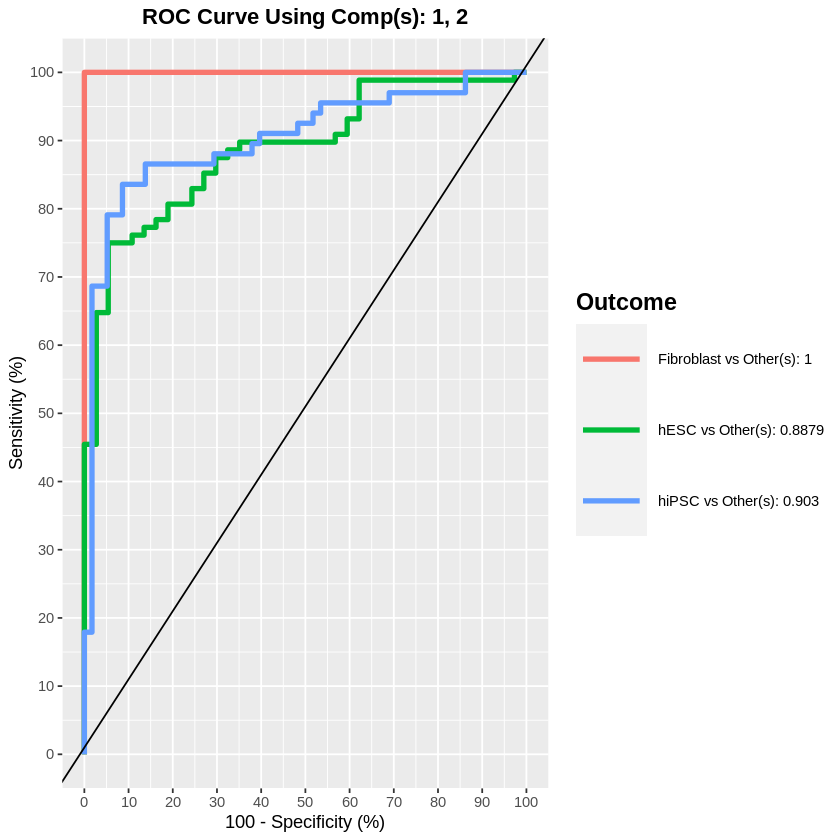

In [ ]:
auc.mint.splsda = auroc(mint.splsda.res, roc.comp = 2)

We can also obtain an AUC plot per study.

$Comp2
                          AUC   p-value
Fibroblast vs Other(s) 1.0000 4.799e-09
hESC vs Other(s)       0.7986 8.518e-02
hiPSC vs Other(s)      0.8921 2.275e-06



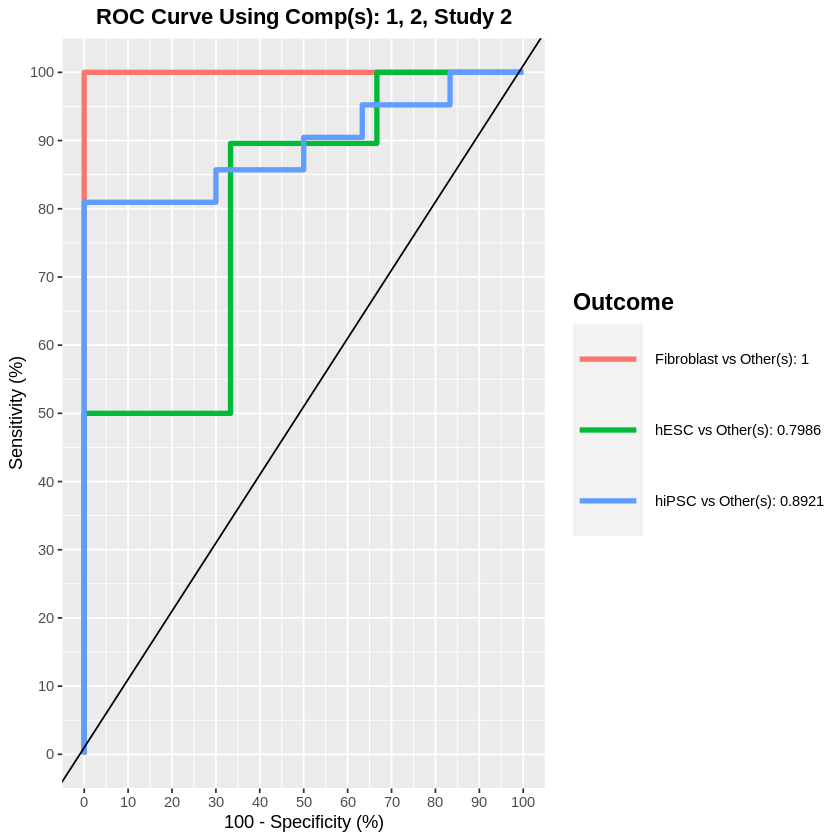

In [ ]:
auc.mint.splsda = auroc(mint.splsda.res, roc.comp = 2, roc.study = '2')